In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import os
import joblib
import tqdm
import pathlib
import collections
import string
import re
import einops

In [2]:
def flickr8k(path='flickr8k'):
  path = pathlib.Path(path)

  if len(list(path.rglob('*'))) < 16197:
    tf.keras.utils.get_file(
        origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip',
        cache_dir='.',
        cache_subdir=path,
        extract=True)
    tf.keras.utils.get_file(
        origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip',
        cache_dir='.',
        cache_subdir=path,
        extract=True)

  captions = (path/"Flickr8k.token.txt").read_text().splitlines()
  captions = (line.split('\t') for line in captions)
  captions = ((fname.split('#')[0], caption) for (fname, caption) in captions)

  cap_dict = collections.defaultdict(list)
  for fname, cap in captions:
    cap_dict[fname].append(cap)

  train_files = (path/'Flickr_8k.trainImages.txt').read_text().splitlines()
  train_captions = [(str(path/'Flicker8k_Dataset'/fname), cap_dict[fname]) for fname in train_files]

  test_files = (path/'Flickr_8k.testImages.txt').read_text().splitlines()
  test_captions = [(str(path/'Flicker8k_Dataset'/fname), cap_dict[fname]) for fname in test_files]

  train_ds = tf.data.experimental.from_list(train_captions)
  test_ds = tf.data.experimental.from_list(test_captions)

  return train_ds, test_ds

In [3]:
train_raw, test_raw = flickr8k('../data/')

In [4]:
train_raw.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(5,), dtype=tf.string, name=None))

In [5]:
for ex_path, ex_captions in train_raw.take(1):
  print(ex_path)
  print(ex_captions)

tf.Tensor(b'..\\data\\Flicker8k_Dataset\\2513260012_03d33305cf.jpg', shape=(), dtype=string)
tf.Tensor(
[b'A black dog is running after a white dog in the snow .'
 b'Black dog chasing brown dog through snow'
 b'Two dogs chase each other across the snowy ground .'
 b'Two dogs play together in the snow .'
 b'Two dogs running through a low lying body of water .'], shape=(5,), dtype=string)


In [6]:
IMAGE_SHAPE=(224, 224, 3)
mobilenet = tf.keras.applications.MobileNetV3Small(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    include_preprocessing=True)
mobilenet.trainable=False

In [7]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    return img

In [8]:
test_img_batch = load_image(ex_path)[tf.newaxis, :]

print(test_img_batch.shape)
print(mobilenet(test_img_batch).shape)

(1, 224, 224, 3)
(1, 7, 7, 576)


In [9]:
def standardize(s):
  s = tf.strings.lower(s)
  s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
  s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
  return s

In [10]:
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(max_tokens=vocabulary_size, standardize=standardize, ragged=True)

In [11]:
tokenizer.adapt(train_raw.map(lambda fp,txt: txt).unbatch().batch(1024))

In [12]:
tokenizer.get_vocabulary()[:10]

['', '[UNK]', 'a', '[START]', '[END]', 'in', 'the', 'on', 'is', 'and']

In [13]:
t = tokenizer([['a cat in a hat'], ['a robot dog']])
t

<tf.RaggedTensor [[3, 2, 655, 5, 2, 97, 4], [3, 2, 1937, 10, 4]]>

In [14]:
word_to_index = tf.keras.layers.StringLookup(mask_token="", vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(mask_token="", vocabulary=tokenizer.get_vocabulary(), invert=True)

In [15]:
w = index_to_word(t)
w.to_list()

[[b'[START]', b'a', b'cat', b'in', b'a', b'hat', b'[END]'],
 [b'[START]', b'a', b'robot', b'dog', b'[END]']]

In [16]:
tf.strings.reduce_join(w, separator=' ', axis=-1).numpy()

array([b'[START] a cat in a hat [END]', b'[START] a robot dog [END]'],
      dtype=object)

In [17]:
def match_shapes(images, captions):
  caption_shape = einops.parse_shape(captions, 'b c')
  captions = einops.rearrange(captions, 'b c -> (b c)')
  images = einops.repeat(images, 'b ... -> (b c) ...', c = caption_shape['c'])
  return images, captions

In [18]:
for ex_paths, ex_captions in train_raw.batch(32).take(1):
  break

print('image paths:', ex_paths.shape)
print('captions:', ex_captions.shape)
print()

ex_paths, ex_captions = match_shapes(images=ex_paths, captions=ex_captions)

print('image_paths:', ex_paths.shape)
print('captions:', ex_captions.shape)

image paths: (32,)
captions: (32, 5)

image_paths: (160,)
captions: (160,)


In [19]:
def prepare_txt(imgs, txts):
  tokens = tokenizer(txts)

  input_tokens = tokens[..., :-1]
  label_tokens = tokens[..., 1:]
  return (imgs, input_tokens), label_tokens

In [20]:
def prepare_dataset(ds, tokenizer, batch_size=32, shuffle_buffer=1000):
  ds = (ds
        .shuffle(10000)
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  def to_tensor(inputs, labels):
    (images, in_tok), out_tok = inputs, labels
    return (images, in_tok.to_tensor()), out_tok.to_tensor()

  return (ds
          .map(match_shapes, tf.data.AUTOTUNE)
          .unbatch()
          .shuffle(shuffle_buffer)
          .batch(batch_size)
          .map(prepare_txt, tf.data.AUTOTUNE)
          .map(to_tensor, tf.data.AUTOTUNE)
          )

In [21]:
train_ds = prepare_dataset(train_raw, tokenizer)
train_ds.element_spec

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [22]:
test_ds = prepare_dataset(test_raw, tokenizer)
test_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [23]:
train_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [24]:
for (inputs, ex_labels) in train_ds.take(1):
  (ex_img, ex_in_tok) = inputs

print(ex_img.shape)
print(ex_in_tok.shape)
print(ex_labels.shape)

(32, 224, 224, 3)
(32, 19)
(32, 19)


In [25]:
print(ex_in_tok[0].numpy())
print(ex_labels[0].numpy())

[   3    2 1074 1397   57  235    6  579   13    6   25   73   65    0
    0    0    0    0    0]
[   2 1074 1397   57  235    6  579   13    6   25   73   65    4    0
    0    0    0    0    0]


In [26]:
class SeqEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, max_length, depth):
    super().__init__()
    self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)

    self.token_embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=depth,
        mask_zero=True)

    self.add = tf.keras.layers.Add()

  def call(self, seq):
    seq = self.token_embedding(seq)

    x = tf.range(tf.shape(seq)[1])
    x = x[tf.newaxis, :]
    x = self.pos_embedding(x)

    return self.add([seq,x])

In [27]:
class CausalSelfAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    attn = self.mha(query=x, value=x,
                    use_causal_mask=True)
    x = self.add([x, attn])
    return self.layernorm(x)

In [28]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x, y, **kwargs):
    attn, attention_scores = self.mha(
             query=x, value=y,
             return_attention_scores=True)

    self.last_attention_scores = attention_scores

    x = self.add([x, attn])
    return self.layernorm(x)

In [29]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, units, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(units=2*units, activation='relu'),
        tf.keras.layers.Dense(units=units),
        tf.keras.layers.Dropout(rate=dropout_rate),
    ])

    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = x + self.seq(x)
    return self.layernorm(x)

In [30]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, units, num_heads=1, dropout_rate=0.1):
    super().__init__()

    self.self_attention = CausalSelfAttention(num_heads=num_heads, key_dim=units, dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=num_heads, key_dim=units, dropout=dropout_rate)
    self.ff = FeedForward(units=units, dropout_rate=dropout_rate)

  def call(self, inputs, training=False):
    in_seq, out_seq = inputs
    out_seq = self.self_attention(out_seq)
    out_seq = self.cross_attention(out_seq, in_seq)
    self.last_attention_scores = self.cross_attention.last_attention_scores
    out_seq = self.ff(out_seq)

    return out_seq

In [31]:
class TokenOutput(tf.keras.layers.Layer):
  def __init__(self, tokenizer, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
    super().__init__()

    self.dense = tf.keras.layers.Dense(
        units=tokenizer.vocabulary_size(), **kwargs)
    self.tokenizer = tokenizer
    self.banned_tokens = banned_tokens

    self.bias = None

  def adapt(self, ds):
    counts = collections.Counter()
    vocab_dict = {name: id 
                  for id, name in enumerate(self.tokenizer.get_vocabulary())}

    for tokens in tqdm.tqdm(ds):
      counts.update(tokens.numpy().flatten())

    counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
    counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())

    counts_arr = counts_arr[:]
    for token in self.banned_tokens:
      counts_arr[vocab_dict[token]] = 0

    total = counts_arr.sum()
    p = counts_arr/total
    p[counts_arr==0] = 1.0
    log_p = np.log(p)

    entropy = -(log_p*p).sum()

    print()
    print(f"Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}")
    print(f"Marginal entropy: {entropy:0.2f}")

    self.bias = log_p
    self.bias[counts_arr==0] = -1e9

  def call(self, x):
    x = self.dense(x)
    return x + self.bias

In [32]:
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

938it [01:50,  8.48it/s]


Uniform entropy: 8.52
Marginal entropy: 5.29


In [33]:
def plot_attention_maps(image, str_tokens, attention_map):
    fig = plt.figure(figsize=(16, 9))
    len_result = len(str_tokens)
    titles = []
    for i in range(len_result):
      map = attention_map[i]
      grid_size = max(int(np.ceil(len_result/2)), 2)
      ax = fig.add_subplot(3, grid_size, i+1)
      titles.append(ax.set_title(str_tokens[i]))
      img = ax.imshow(image)
      ax.imshow(map, cmap='gray', alpha=0.6, extent=img.get_extent(), clim=[0.0, np.max(map)])

    plt.tight_layout()

In [34]:
class Captioner(tf.keras.Model):
  def __init__(self, tokenizer, feature_extractor, output_layer, num_layers=1, units=256, max_length=50, num_heads=1, dropout_rate=0.1):
    super().__init__()
    self.feature_extractor = feature_extractor
    self.tokenizer = tokenizer
    self.word_to_index = tf.keras.layers.StringLookup(mask_token="", vocabulary=tokenizer.get_vocabulary())
    self.index_to_word = tf.keras.layers.StringLookup(mask_token="", vocabulary=tokenizer.get_vocabulary(), invert=True) 
    self.seq_embedding = SeqEmbedding(vocab_size=tokenizer.vocabulary_size(), depth=units, max_length=max_length)
    self.decoder_layers = [DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate) for n in range(num_layers)]
    self.output_layer = output_layer

  def call(self, inputs):
      image, txt = inputs
      if image.shape[-1] == 3:
          image = self.feature_extractor(image)
      image = einops.rearrange(image, 'b h w c -> b (h w) c')
      if txt.dtype == tf.string:
          txt = self.tokenizer(txt)
      txt = self.seq_embedding(txt)
      for dec_layer in self.decoder_layers:
          txt = dec_layer(inputs=(image, txt))
      txt = self.output_layer(txt)
      return txt

  def simple_gen(self, image, temperature=1):
    initial = self.word_to_index([['[START]']])
    img_features = self.feature_extractor(image[tf.newaxis, ...])
    tokens = initial
    for n in range(50):
      preds = self((img_features, tokens)).numpy()
      preds = preds[:,-1, :]
      if temperature==0:
          next = tf.argmax(preds, axis=-1)[:, tf.newaxis]
      else:
          next = tf.random.categorical(preds/temperature, num_samples=1)
      tokens = tf.concat([tokens, next], axis=1)

      if next[0] == self.word_to_index('[END]'):
        break
    words = self.index_to_word(tokens[0, 1:-1])
    result = tf.strings.reduce_join(words, axis=-1, separator=' ')
    return result.numpy().decode()

  def run_and_show_attention(self, image, temperature=0.0):
    result_txt = self.simple_gen(image, temperature)
    str_tokens = result_txt.split()
    str_tokens.append('[END]')

    attention_maps = [layer.last_attention_scores for layer in self.decoder_layers]
    attention_maps = tf.concat(attention_maps, axis=0)
    attention_maps = einops.reduce(attention_maps, 'batch heads sequence (height width) -> sequence height width', height=7, width=7, reduction='mean')

    plot_attention_maps(image/255, str_tokens, attention_maps)
    t = plt.suptitle(result_txt)
    t.set_y(1.05)

In [35]:
model = Captioner(tokenizer, feature_extractor=mobilenet, output_layer=output_layer, units=256, dropout_rate=0.5, num_layers=2, num_heads=2)

In [36]:
def masked_loss(labels, preds):  
  labels = tf.cast(labels, tf.int64)
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

  mask = (labels != 0) & (loss < 1e8) 
  mask = tf.cast(mask, loss.dtype)

  loss = loss*mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

In [37]:
def masked_acc(labels, preds):
  mask = tf.cast(labels!=0, tf.float32)
  preds = tf.argmax(preds, axis=-1)
  labels = tf.cast(labels, tf.int64)
  match = tf.cast(preds == labels, mask.dtype)
  acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
  return acc

In [38]:
class GenerateText(tf.keras.callbacks.Callback):
  def __init__(self):
    super(GenerateText, self).__init__()
    self.image = load_image('../data/Flicker8k_Dataset/667626_18933d713e.jpg')

  def on_epoch_end(self, epochs=None, logs=None):
    print()
    print()
    for t in (0.0, 0.5, 1.0):
      result = self.model.simple_gen(self.image, temperature=t)
      print(result)
    print()

In [39]:
callbacks = [GenerateText(), tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]

In [40]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=masked_loss, metrics=[masked_acc])

In [41]:
history = model.fit(train_ds.repeat(), steps_per_epoch=100, validation_data=test_ds.repeat(), validation_steps=20, epochs=100, callbacks=callbacks)

Epoch 1/100


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\layer.py:361: UserWarning: `build()` was called on layer 'captioner', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 5.0007 - masked_acc: 0.1937



c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


a man in a man in a man
the dog in a red dog is in the water
a

100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 260ms/step - loss: 4.9989 - masked_acc: 0.1940 - val_loss: 4.5377 - val_masked_acc: 0.2559
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 4.4315 - masked_acc: 0.2737

a man in a red and a man in the grass
a girl is in a white shirt in a bicycle
a young bicycle sits on a near a clear yellow dog

100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 194ms/step - loss: 4.4312 - masked_acc: 0.2737 - val_loss: 4.2225 - val_masked_acc: 0.2913
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 4.2118 - masked_acc: 0.2990

a man in a red shirt is running on a red
a boy in a large man in the background
a white woman to performing an bed dad of a air

100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 188ms/step - loss: 4.2118 - masked_acc: 0.2990 - val_loss: 4.0575 - val_masked_acc: 0.3040
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 4.1079 - masked_acc: 0.3113

a man in a red shirt is playin

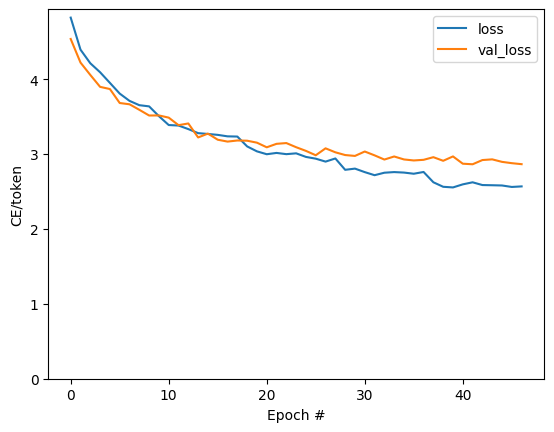

In [42]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

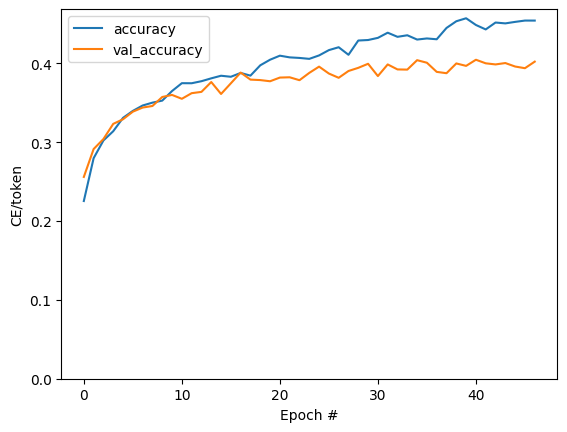

In [43]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [46]:
image = load_image('../data/Flicker8k_Dataset/667626_18933d713e.jpg')

In [47]:
result = model.simple_gen(image, temperature=0.0)
result

c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


'a young girl in a red shirt is walking on a red wall'

In [48]:
str_tokens = result.split()
str_tokens.append('[END]')

In [49]:
attn_maps = [layer.last_attention_scores for layer in model.decoder_layers]
[map.shape for map in attn_maps]

[TensorShape([1, 2, 14, 49]), TensorShape([1, 2, 14, 49])]

In [50]:
attention_maps = tf.concat(attn_maps, axis=0)
attention_maps = einops.reduce(attention_maps, 'batch heads sequence (height width) -> sequence height width', height=7, width=7, reduction='mean')

In [51]:
einops.reduce(attention_maps, 'sequence height width -> sequence', reduction='sum')

<tf.Tensor: shape=(14,), dtype=float32, numpy=
array([1.        , 1.        , 1.        , 1.        , 1.        ,
       0.99999994, 0.99999994, 1.0000001 , 1.        , 1.        ,
       1.        , 0.99999994, 1.        , 1.        ], dtype=float32)>

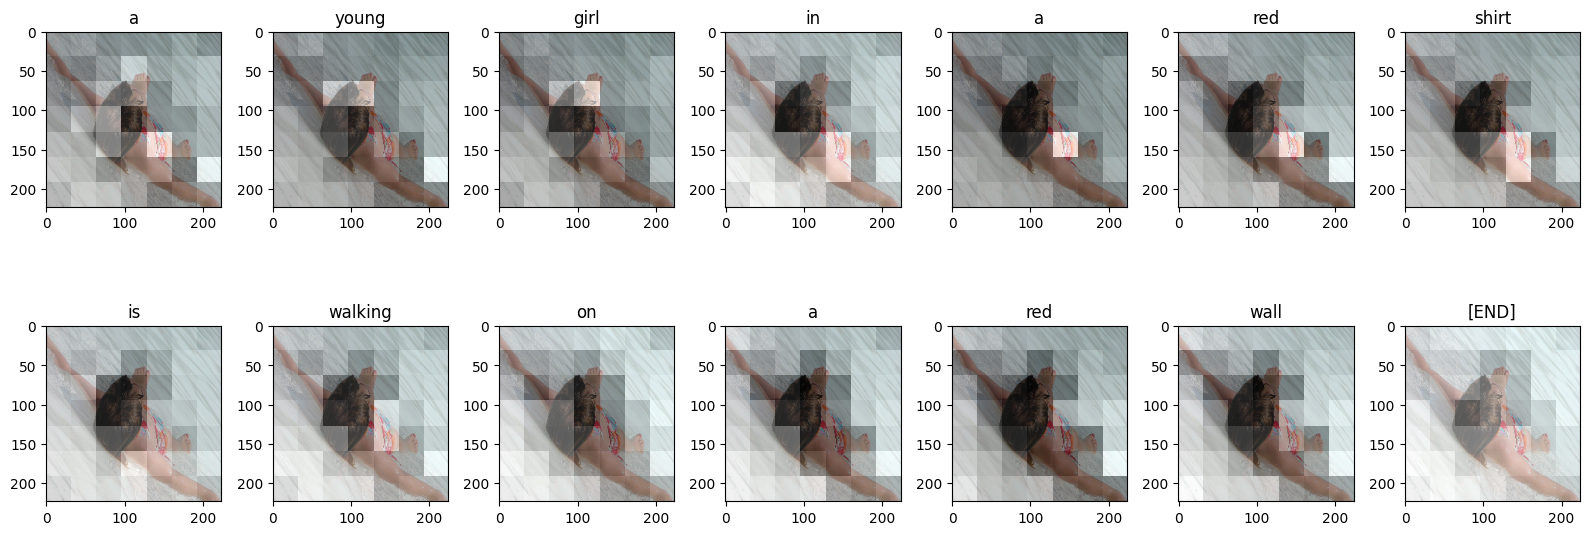

In [52]:
plot_attention_maps(image/255, str_tokens, attention_maps)

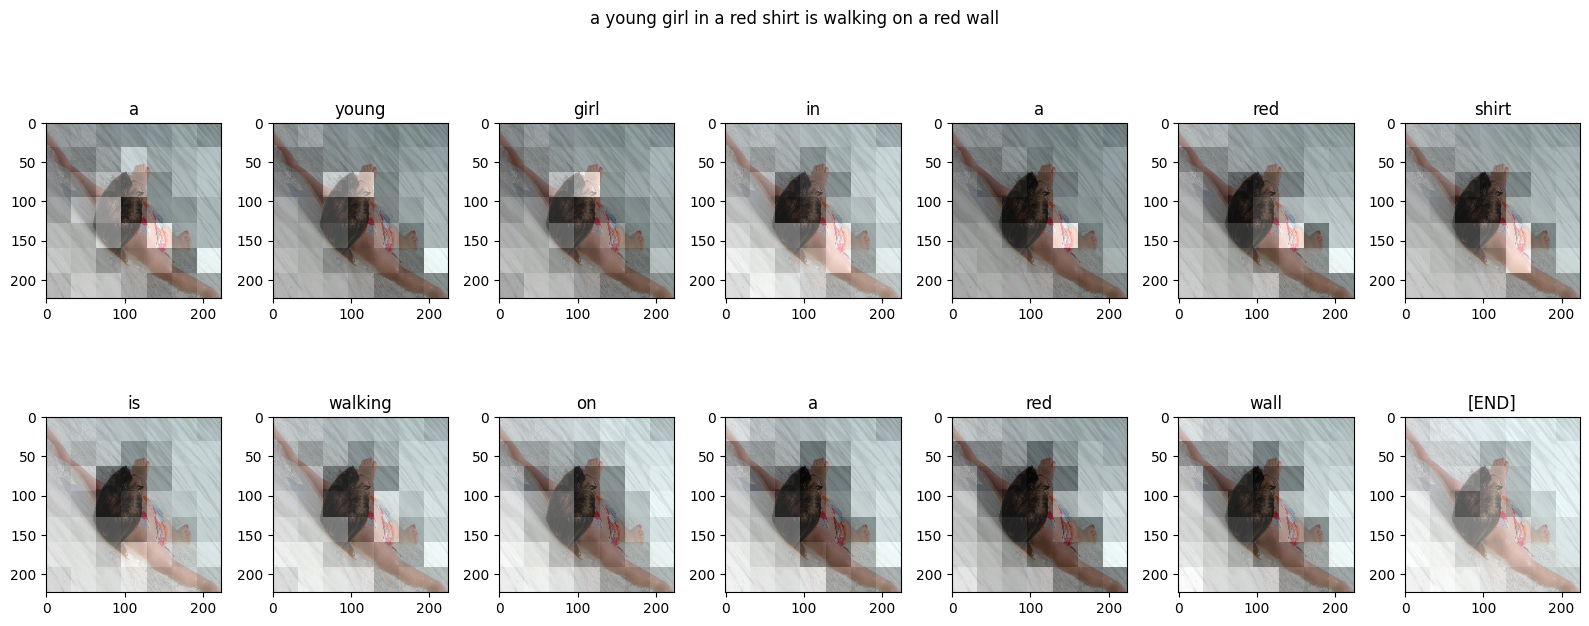

In [53]:
model.run_and_show_attention(image)

In [54]:
joblib.dump(model, 'transformer.joblib')

['transformer.joblib']